## Importing the necessary libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np
import cv2

In [4]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

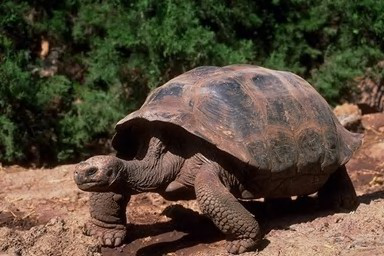

In [5]:
real_image_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00003.jpg'
Image.open(real_image_path)

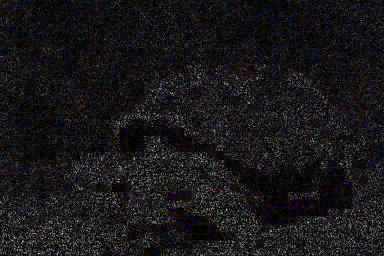

In [6]:
convert_to_ela_image(real_image_path, 85)


In [7]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

In [8]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

## Processing Authentic Images

In [9]:
import random
count = 0
path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:

        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)  
        if len(Y) % 1000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 1000 == 0:
        break

random.shuffle(X)
# X = X[:2100]
# Y = Y[:2100]
print(len(X), len(Y))

Processing 1000 images
1000 1000


In [10]:
len(X),len(Y)


(1000, 1000)

## Processing Tampering Images¶


In [11]:
x_t, y_t = [], []

path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
count = 0
for dirname, _, filenames in os.walk(path):
    for filename in filenames:

        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
        if len(Y) % 2000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 1700 == 0:
        break

print(len(X), len(Y))

Processing 2000 images
2000 2000


## Shuffling the data

In [12]:
from sklearn.utils import shuffle
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

## Resizing the image to fit the data¶


In [13]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

1600 1600
400 400


## IMAGE AUGMENTATION:

Image augmentation is a technique of altering the existing data to create some more data for the model training process. In other words, it is the process of artificially expanding the available dataset for training a deep learning model.

### Importing the libraries

In [14]:
import urllib

import numpy as np 
import pandas as pd 

from skimage.transform import rotate
from tqdm import tqdm
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

# !pip install git+https://github.com/tensorflow/docs

# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots

import tensorflow_datasets as tfds

### Loading a sample image

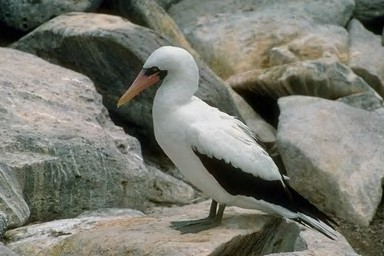

In [15]:
sample_image_path = tf.keras.utils.load_img("/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00013.jpg")
sample_image_path

In [16]:
tf_image = np.array(sample_image_path)


### CREATION OF A FUNCTION TO VISUALIZE THE COMPARISON BETWEEN THE ORIGINAL IMAGE AND THE AUGMENTED IMAGE:



In [17]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### ROTATING THE IMAGE:

- One of the most commonly used augmentation techniques is image rotation.

- Even if we rotate the image, the information on the image remains the same.

- A bird is a bird, even if we see it from a different angle.

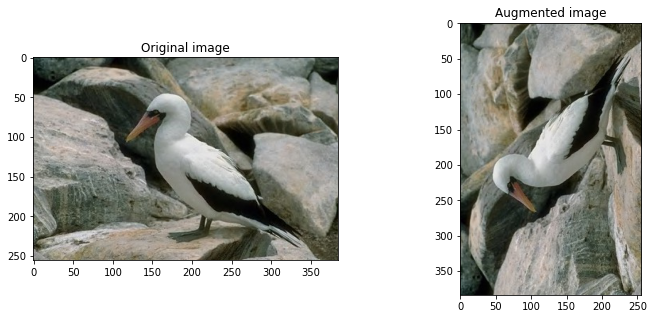

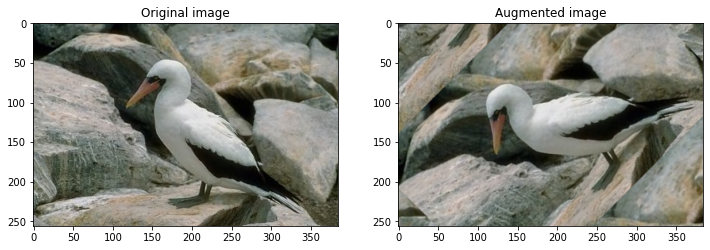

In [18]:
#Rotating the image to 90 degree angle
rotated_image = tf.image.rot90(tf_image)
visualize(tf_image, rotated_image)

#Rotating the image to 45 degree angle
rotated = rotate(tf_image, angle=45, mode = 'wrap')
visualize(tf_image, rotated)

### FLIPPING THE IMAGE:

- Flipping can be considered as an extension of rotation.

- It allows us to flip the image in the Left-Right direction as well as the Up-Down direction.

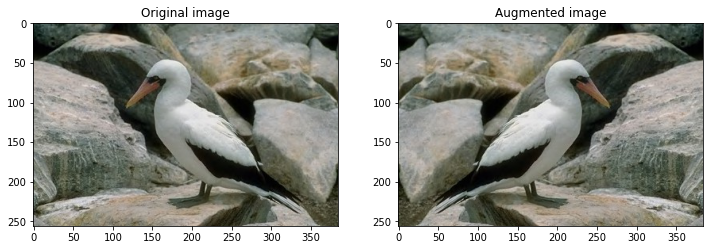

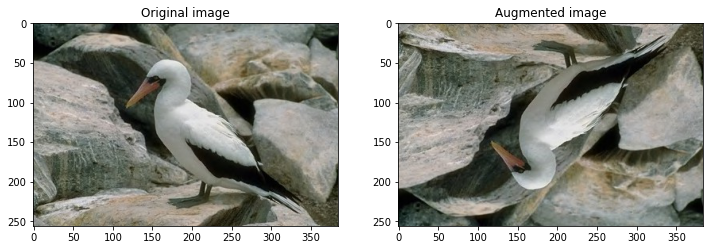

In [19]:
#flip the image in the Left-Right direction
flipped_image_left_right = tf.image.flip_left_right(tf_image)
visualize(tf_image, flipped_image_left_right)

#flip the image in the Up-Down direction
flipped_image_up_down = tf.image.flip_up_down(tf_image)
visualize(tf_image, flipped_image_up_down)

### APPLYING THE GRAYSCALE FEATURES TO THE IMAGE:



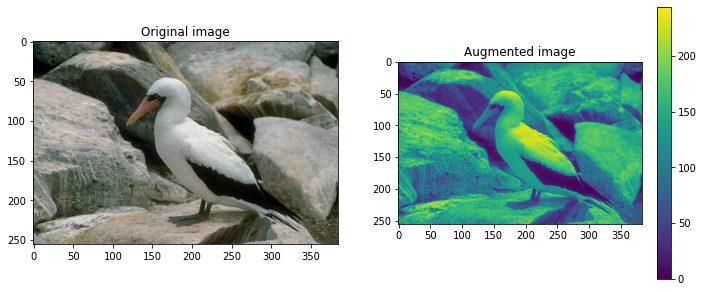

In [20]:
grayscaled_image = tf.image.rgb_to_grayscale(tf_image)
visualize(tf_image, tf.squeeze(grayscaled_image))
plt.colorbar()

### ADDING THE SATURATION FACTOR TO THE IMAGE:

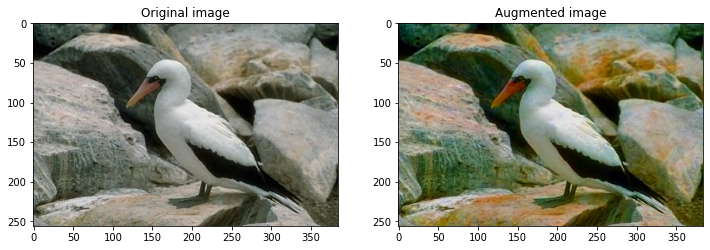

In [21]:
saturated_image = tf.image.adjust_saturation(tf_image, 3)
visualize(tf_image, saturated_image)

### CROPPING THE IMAGE:

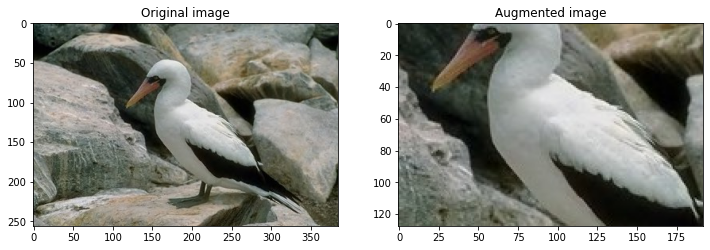

In [22]:
cropped_image = tf.image.central_crop(tf_image, central_fraction=0.5)
visualize(tf_image,cropped_image)

### SHIFTING THE IMAGE:

- By shifting the images, we can change the position of the objects in the image and hence give more variety to the model.

- Shifting the image eventually can result in a more generalized model.

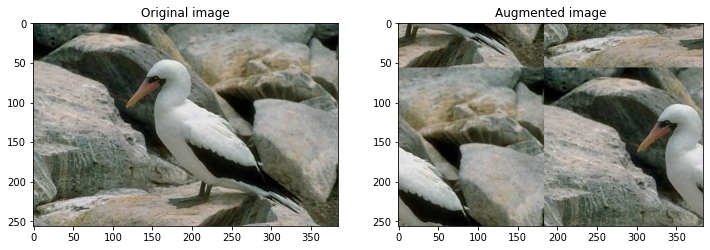

In [23]:
#apply shift operation
transform = AffineTransform(translation=(200,200))
wrapShift = warp(tf_image,transform,mode='wrap')
visualize(tf_image,wrapShift)

### IMAGE NOISING:

- Another popularly used image augmentation technique is, Image Noising where we add noise to the image.

- This technique allows our model to learn how to separate the signal from the noise in the image.

- This also makes our model more robust to changes in the image

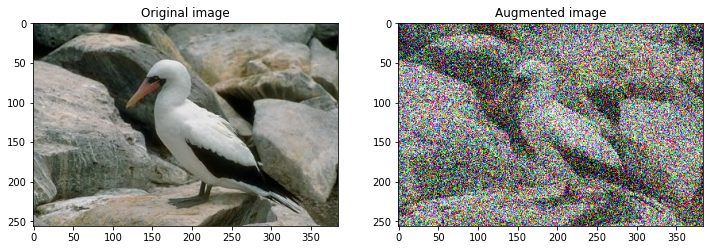

In [24]:
#standard deviation for noise to be added in the image
sigma=0.155
#add random noise to the image
noisyRandom = random_noise(tf_image,var=sigma**0.5)
visualize(tf_image,noisyRandom)

### APPLYING THE DATA AUGMENTATION FEATURES ON A DATASET:


In [87]:
def convert(tf_image, label):
  tf_image = tf.image.convert_image_dtype(tf_image, tf.float32) # Cast and normalize the image to [0,1]
  return tf_image, label

def augment(tf_image,label):
  tf_image,label = convert(tf_image, label)
  tf_image = tf.image.rot90(tf_image) #Rotate Image by 90 degrees
  tf_image = tf.image.resize_with_crop_or_pad(tf_image, 34, 34) # Add 6 pixels of padding
  tf_image = tf.image.rgb_to_grayscale(tf_image) # APPLYING THE GRAYSCALE FEATURES TO THE IMAGE
  tf_image = tf.image.random_brightness(tf_image, max_delta=0.5) # Random brightness

  return tf_image,label
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit
NUM_EXAMPLES = 2048

### CREATION OF A AUGMENTED DATASET:



In [106]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os, warnings

ds_train_ = image_dataset_from_directory(
    '../input/casia-20-image-tampering-detection-dataset/CASIA2/',
    labels='inferred',
    image_size=[128, 128],
    validation_split=0.2,
    subset='training',
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_valid_ = image_dataset_from_directory(
    '../input/casia-20-image-tampering-detection-dataset/CASIA2/',
    labels='inferred',
    image_size=[128, 128],
    subset='validation',
    seed=123,
    validation_split=0.2,
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)


AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(augment)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(augment)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 14678 files belonging to 3 classes.
Using 11743 files for training.
Found 14678 files belonging to 3 classes.
Using 2935 files for validation.
